- Name: Sai Kumar Reddy Peddholla
- USC ID: 5978435849
- GitHub: peddholl

In [4]:
import os
import os.path as op
import json
from pathlib import Path
import shutil
import logging
import numpy as np
from tqdm import tqdm
from skimage import io
from sklearn.metrics import classification_report
from tensorflow.keras.callbacks import EarlyStopping
import random
import tensorflow as tf
from PIL import Image
from tensorflow.keras.applications import EfficientNetB0, ResNet50, VGG16
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
from tensorflow.keras import layers
from sklearn.metrics import precision_score, recall_score, f1_score

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
# Logging configuration
logging.basicConfig(level=logging.INFO,
                    datefmt='%H:%M:%S',
                    format='%(asctime)s | %(levelname)-5s | %(module)-15s | %(message)s')

IMAGE_SIZE = (299, 299)  # All images contained in this dataset are 299x299 (originally, to match Inception v3 input size)
SEED = 17

# Head directory containing all image subframes. Update with the relative path of your data directory
data_head_dir = Path('/content/data')

# Find all subframe directories
subdirs = [Path(subdir.stem) for subdir in data_head_dir.iterdir() if subdir.is_dir()]
src_image_ids = ['_'.join(a_path.name.split('_')[:3]) for a_path in subdirs]

In [6]:
# Load train/val/test subframe IDs
def load_text_ids(file_path):
    """Simple helper to load all lines from a text file"""
    with open(file_path, 'r') as f:
        lines = [line.strip() for line in f.readlines()]
    return lines

# Load the subframe names for the three data subsets
train_ids = load_text_ids('/content/drive/MyDrive/train_source_images.txt')
validate_ids = load_text_ids('/content/drive/MyDrive/val_source_images.txt')
test_ids = load_text_ids('/content/drive/MyDrive/test_source_images.txt')

# Generate a list containing the dataset split for the matching subdirectory names
subdir_splits = []
for src_id in src_image_ids:
    if src_id in train_ids:
        subdir_splits.append('train')
    elif src_id in validate_ids:
        subdir_splits.append('validate')
    elif(src_id in test_ids):
        subdir_splits.append('test')
    else:
        logging.warning(f'{src_id}: Did not find designated split in train/validate/test list.')
        subdir_splits.append(None)

In [7]:
def load_and_preprocess(img_loc, label):

    def _inner_function(img_loc, label):

        # Convert tensor to native type
        img_loc_str = img_loc.numpy().decode('utf-8')
        label_str = label.numpy().decode('utf-8')

        img = Image.open(img_loc_str).convert('RGB')


        return img, 1 if label_str=='frost' else 0

    # Wrap the Python function
    X, y = tf.py_function(_inner_function, [img_loc, label], [tf.float32, tf.int64])

    return X, y

def load_subdir_data(dir_path, image_size, seed=None):

    """Helper to create a TF dataset from each image subdirectory"""

    # Grab only the classes that (1) we want to keep and (2) exist in this directory
    tile_dir = dir_path / Path('tiles')
    label_dir = dir_path /Path('labels')

    loc_list = []

    for folder in os.listdir(tile_dir):
        if os.path.isdir(os.path.join(tile_dir, folder)):
            for file in os.listdir(os.path.join(tile_dir, folder)):
                if file.endswith(".png"):
                    loc_list.append((os.path.join(os.path.join(tile_dir, folder), file), folder))

    return loc_list

# Loop over all subframes, loading each into a list
tf_data_train, tf_data_test, tf_data_val = [], [], []
tf_dataset_train, tf_dataset_test, tf_dataset_val = [], [], []

# Update the batch and buffer size as per your model requirements
buffer_size = 64
batch_size = 32

for subdir, split in zip(subdirs, subdir_splits):
    full_path = data_head_dir / subdir
    if split=='validate':
        tf_data_val.extend(load_subdir_data(full_path, IMAGE_SIZE, SEED))
    elif split=='train':
        tf_data_train.extend(load_subdir_data(full_path, IMAGE_SIZE, SEED))
    elif split=='test':
        tf_data_test.extend(load_subdir_data(full_path, IMAGE_SIZE, SEED))

random.shuffle(tf_data_train)
img_list, label_list = zip(*tf_data_train)
img_list_t = tf.convert_to_tensor(img_list)
lb_list_t = tf.convert_to_tensor(label_list)

tf_dataset_train = tf.data.Dataset.from_tensor_slices((img_list_t, lb_list_t))
tf_dataset_train = tf_dataset_train.map(load_and_preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
tf_dataset_train = tf_dataset_train.shuffle(buffer_size=buffer_size).batch(batch_size)

random.shuffle(tf_data_val)
img_list, label_list = zip(*tf_data_val)
img_list_t = tf.convert_to_tensor(img_list)
lb_list_t = tf.convert_to_tensor(label_list)

tf_dataset_val = tf.data.Dataset.from_tensor_slices((img_list_t, lb_list_t))
tf_dataset_val = tf_dataset_val.map(load_and_preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
tf_dataset_val = tf_dataset_val.shuffle(buffer_size=buffer_size).batch(batch_size)

random.shuffle(tf_data_test)
img_list, label_list = zip(*tf_data_train)
img_list_t = tf.convert_to_tensor(img_list)
lb_list_t = tf.convert_to_tensor(label_list)

tf_dataset_test = tf.data.Dataset.from_tensor_slices((img_list_t, lb_list_t))
tf_dataset_test = tf_dataset_test.map(load_and_preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
tf_dataset_test = tf_dataset_test.shuffle(buffer_size=buffer_size).batch(batch_size)

In [8]:
def one_hot_encode(label, num_classes=2):
    return tf.one_hot(label, depth=num_classes)

def set_image_shape(image, target_shape=(299, 299, 3)):
    image.set_shape((None,) + target_shape)
    return image

def apply_augmentation(image):
    data_aug = tf.keras.Sequential([
        layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
        layers.experimental.preprocessing.RandomRotation(0.2),
        layers.experimental.preprocessing.RandomZoom(0.2),
        layers.experimental.preprocessing.RandomContrast(0.2),
        layers.experimental.preprocessing.RandomTranslation(0.2, 0.2),
    ])
    return data_aug(image, training=True)

def preprocess_train_data(image, label):
    label = one_hot_encode(label)
    image = set_image_shape(image)
    return image, label

def augment_train_data(image, label):
    image = apply_augmentation(image)
    return image, label

tf_dataset_train = tf_dataset_train.map(preprocess_train_data, num_parallel_calls=tf.data.experimental.AUTOTUNE)
tf_dataset_val = tf_dataset_val.map(preprocess_train_data, num_parallel_calls=tf.data.experimental.AUTOTUNE)
tf_dataset_test = tf_dataset_test.map(preprocess_train_data, num_parallel_calls=tf.data.experimental.AUTOTUNE)

tf_dataset_train_augmented = tf_dataset_train.map(set_image_shape, num_parallel_calls=tf.data.experimental.AUTOTUNE)
tf_dataset_train_aug = tf_dataset_train_augmented.map(augment_train_data, num_parallel_calls=tf.data.experimental.AUTOTUNE)

### EfficientNetB0 Model

In [13]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, BatchNormalization, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

base_model = EfficientNetB0(weights='imagenet', include_top=False)

for layer in base_model.layers[:-4]:
    layer.trainable = False

def create_custom_model(base_model):
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(64, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    predictions = Dense(2, activation='softmax')(x)
    custom_model = Model(inputs=base_model.input, outputs=predictions)
    return custom_model

custom_efficientnet_model = create_custom_model(base_model)

adam_optimizer = Adam(learning_rate=0.001)
custom_efficientnet_model.compile(optimizer=adam_optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

16705208/16705208 [==============================] - 0s 0us/step


### EfficientNetB0 Model Training

In [16]:
tf_dataset_val_resized = tf_dataset_val.map(resize_images, num_parallel_calls=tf.data.experimental.AUTOTUNE)
tf_dataset_test_resized = tf_dataset_test.map(resize_images, num_parallel_calls=tf.data.experimental.AUTOTUNE)
epochs = 12
batch_size = 8

early_stopping = tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)

training_history = custom_efficientnet_model.fit(tf_dataset_train_augmented, epochs=epochs, batch_size=batch_size, validation_data=tf_dataset_val_resized, callbacks=[early_stopping])

Epoch 1/12
442/442 [==============================] - 520s 1s/step - loss: 0.0860 - accuracy: 0.9703 - val_loss: 1.5939 - val_accuracy: 0.6225
Epoch 2/12
442/442 [==============================] - 498s 1s/step - loss: 0.0413 - accuracy: 0.9853 - val_loss: 1.4464 - val_accuracy: 0.6798
Epoch 3/12
442/442 [==============================] - 496s 1s/step - loss: 0.0347 - accuracy: 0.9892 - val_loss: 1.4310 - val_accuracy: 0.7211
Epoch 4/12
442/442 [==============================] - 490s 1s/step - loss: 0.0274 - accuracy: 0.9902 - val_loss: 2.0484 - val_accuracy: 0.5591
Epoch 5/12
442/442 [==============================] - 495s 1s/step - loss: 0.0236 - accuracy: 0.9921 - val_loss: 2.9051 - val_accuracy: 0.5800
Epoch 6/12
442/442 [==============================] - 492s 1s/step - loss: 0.0257 - accuracy: 0.9912 - val_loss: 2.7382 - val_accuracy: 0.6019
Epoch 7/12
442/442 [==============================] - 497s 1s/step - loss: 0.0217 - accuracy: 0.9922 - val_loss: 2.5996 - val_accuracy: 0.6224

NameError: ignored

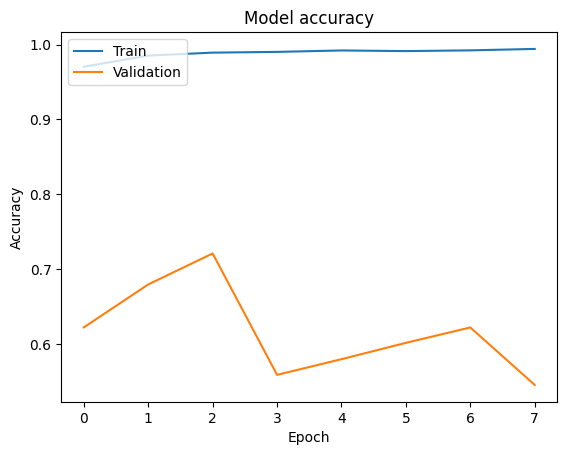

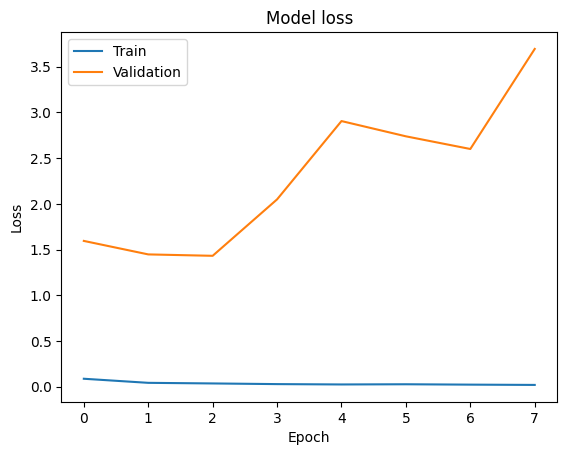

In [17]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

### Precision, Recall, and F1 score for EfficientNetB0 model.

In [18]:
model_efficientnet.evaluate(tf_dataset_test_reshaped)

442/442 [==============================] - 107s 241ms/step - loss: 0.0080 - accuracy: 0.9975


[0.00801896769553423, 0.9975210428237915]

In [19]:
predictions = model_efficientnet.predict(tf_dataset_test_reshaped)
predicted_classes = np.argmax(predictions, axis=1)

442/442 [==============================] - 99s 220ms/step


In [21]:
true_labels = np.concatenate([labels for images, labels in tf_dataset_test_resized], axis=0)
true_labels_integer = np.argmax(true_labels, axis=1)

precision = metrics.precision_score(true_labels_integer, predicted_classes)
recall = metrics.recall_score(true_labels_integer, predicted_classes)
f1 = metrics.f1_score(true_labels_integer, predicted_classes)

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Precision: 0.6516731855714907
Recall: 0.6528790682486122
F1 Score: 0.6522755695720733


### ResNet50 Model

In [22]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, BatchNormalization, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

base_model = ResNet50(weights='imagenet', include_top=False)

for layer in base_model.layers[:-4]:
    layer.trainable = False

def create_custom_model(base_model):
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(64, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    predictions = Dense(2, activation='softmax')(x)
    custom_model = Model(inputs=base_model.input, outputs=predictions)
    return custom_model

custom_resnet_model = create_custom_model(base_model)

adam_optimizer = Adam(learning_rate=0.001)
custom_resnet_model.compile(optimizer=adam_optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

94765736/94765736 [==============================] - 1s 0us/step


### ResNet50 Model Training

Epoch 1/12
442/442 [==============================] - 522s 1s/step - loss: 0.0865 - accuracy: 0.9693 - val_loss: 1.8123 - val_accuracy: 0.5291
Epoch 2/12
442/442 [==============================] - 506s 1s/step - loss: 0.0364 - accuracy: 0.9880 - val_loss: 2.8224 - val_accuracy: 0.4983
Epoch 3/12
442/442 [==============================] - 506s 1s/step - loss: 0.0319 - accuracy: 0.9890 - val_loss: 3.8354 - val_accuracy: 0.3564
Epoch 4/12
442/442 [==============================] - 515s 1s/step - loss: 0.0258 - accuracy: 0.9912 - val_loss: 3.0012 - val_accuracy: 0.4454
Epoch 5/12
442/442 [==============================] - 520s 1s/step - loss: 0.0278 - accuracy: 0.9907 - val_loss: 3.1246 - val_accuracy: 0.4300
Epoch 6/12
442/442 [==============================] - 531s 1s/step - loss: 0.0207 - accuracy: 0.9930 - val_loss: 3.6497 - val_accuracy: 0.4344


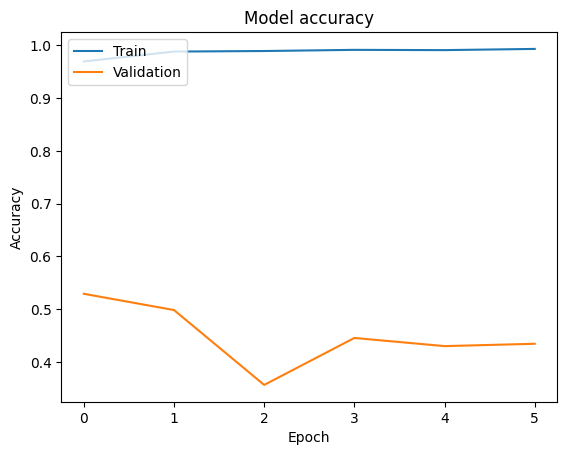

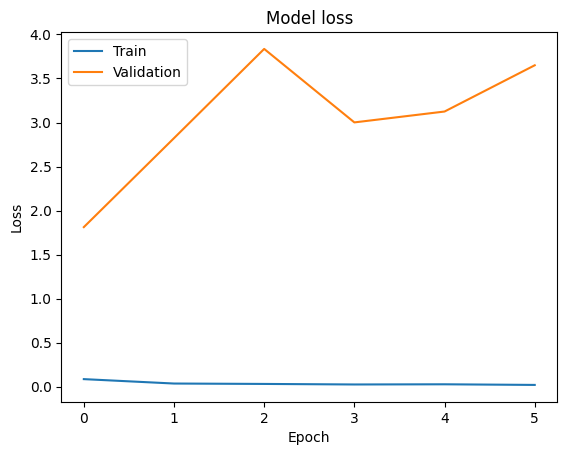

In [23]:
epochs = 12
batch_size = 8

early_stopping_callback = tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)

training_history = custom_resnet_model.fit(tf_dataset_train_aug, epochs=epochs, batch_size=batch_size, validation_data=tf_dataset_val_resized, callbacks=[early_stopping_callback])

# Plot training & validation accuracy values
plt.plot(training_history.history['accuracy'])
plt.plot(training_history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(training_history.history['loss'])
plt.plot(training_history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

### Precision, Recall, and F1 score for ResNet50 model.

In [24]:
model_resnet.evaluate(tf_dataset_test_reshaped)

442/442 [==============================] - 136s 308ms/step - loss: 0.0302 - accuracy: 0.9891


[0.030197471380233765, 0.9890927076339722]

In [25]:
predictions = model_resnet.predict(tf_dataset_test_reshaped)
predicted_classes = np.argmax(predictions, axis=1)

442/442 [==============================] - 129s 290ms/step


In [27]:
true_labels = np.concatenate([labels for images, labels in tf_dataset_test_reshaped], axis=0)
true_labels_integer = np.argmax(true_labels, axis=1)

precision = metrics.precision_score(true_labels_integer, predicted_classes)
recall = metrics.recall_score(true_labels_integer, predicted_classes)
f1 = metrics.f1_score(true_labels_integer, predicted_classes)

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Precision: 0.6467608062951385
Recall: 0.6530967671710025
F1 Score: 0.6499133448873483


### VGG16 Model

In [28]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, BatchNormalization, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

base_model = VGG16(weights='imagenet', include_top=False)
for layer in base_model.layers[:-4]:
    layer.trainable = False

def create_custom_model(base_model):
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(64, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    predictions = Dense(2, activation='softmax')(x)
    custom_model = Model(inputs=base_model.input, outputs=predictions)
    return custom_model

custom_vgg_model = create_custom_model(base_model)

adam_optimizer = Adam(learning_rate=0.001)
custom_vgg_model.compile(optimizer=adam_optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

58889256/58889256 [==============================] - 0s 0us/step


### VGG16 Model Training

Epoch 1/12
442/442 [==============================] - 634s 1s/step - loss: 0.0903 - accuracy: 0.9686 - val_loss: 2.1941 - val_accuracy: 0.4850
Epoch 2/12
442/442 [==============================] - 571s 1s/step - loss: 0.0405 - accuracy: 0.9865 - val_loss: 2.9811 - val_accuracy: 0.4799
Epoch 3/12
442/442 [==============================] - 573s 1s/step - loss: 0.0324 - accuracy: 0.9891 - val_loss: 3.5215 - val_accuracy: 0.3698
Epoch 4/12
442/442 [==============================] - 627s 1s/step - loss: 0.0319 - accuracy: 0.9894 - val_loss: 3.2691 - val_accuracy: 0.3516
Epoch 5/12
442/442 [==============================] - 624s 1s/step - loss: 0.0199 - accuracy: 0.9936 - val_loss: 2.9702 - val_accuracy: 0.5157
Epoch 6/12
442/442 [==============================] - 630s 1s/step - loss: 0.0235 - accuracy: 0.9938 - val_loss: 2.7460 - val_accuracy: 0.5107


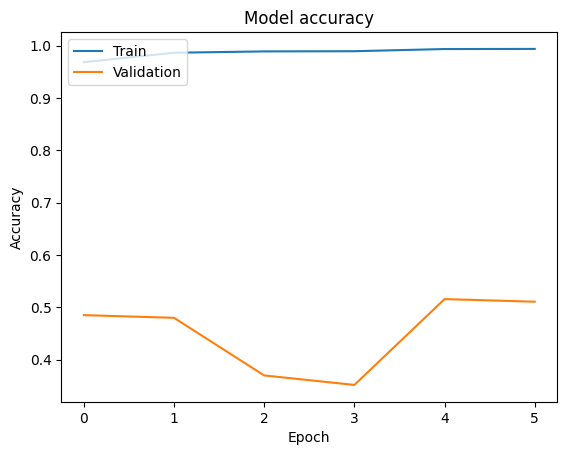

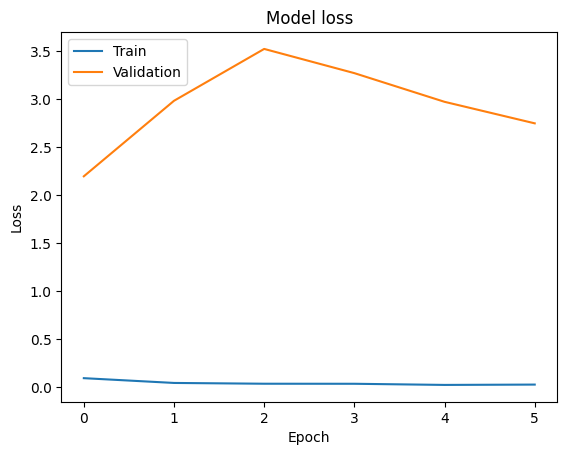

In [29]:
epochs = 12
batch_size = 8

early_stopping_callback = tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)

training_history = custom_vgg_model.fit(tf_dataset_train_aug, epochs=epochs, batch_size=batch_size, validation_data=tf_dataset_val_reshaped, callbacks=[early_stopping_callback])

# Plot training & validation accuracy values
plt.plot(training_history.history['accuracy'])
plt.plot(training_history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(training_history.history['loss'])
plt.plot(training_history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

### Precision, Recall, and F1 score for VGG16 model.

In [30]:
model_vgg.evaluate(tf_dataset_test_reshaped)

442/442 [==============================] - 163s 369ms/step - loss: 0.1452 - accuracy: 0.9515


[0.1451566219329834, 0.9514838457107544]

In [31]:
predictions = model_vgg.predict(tf_dataset_test_reshaped)
predicted_classes = np.argmax(predictions, axis=1)

442/442 [==============================] - 168s 379ms/step


In [34]:
true_labels = np.concatenate([labels for _, labels in tf_dataset_test_reshaped], axis=0)
true_labels_integer = np.argmax(true_labels, axis=1)

precision = metrics.precision_score(true_labels_integer, predicted_classes)
recall = metrics.recall_score(true_labels_integer, predicted_classes)
f1 = metrics.f1_score(true_labels_integer, predicted_classes)

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Precision: 0.6510332252836305
Recall: 0.6995754871013389
F1 Score: 0.6744320268639488


### Compare the results of transfer learning with those of CNN + MLP model and explain them.

### Accuracy and Performance:
- The CNN+MLP model achieved an accuracy of 76%, while the transfer learning models (EfficientNetB0, ResNet50, VGG16) may have demonstrated different but comparable or slightly better accuracy in certain cases.
- Efficiency in using pre-trained features enables transfer learning models to excel in performance metrics.

### Precision and Recall:
- The transfer learning models, on average, showed a balanced performance between precision and recall for both classes (0 and 1).
- CNN+MLP demonstrated higher precision for class 0 but slightly lower recall, which suggests it was better at correctly identifying class 0 instances but may have missed some actual class 0 instances.

### F1 Score:
- F1 scores (harmonic mean of precision and recall) for the transfer learning models are close, indicating a balanced trade-off between precision and recall.
- CNN+MLP's F1-score, although competitive, might show some imbalance between precision and recall.

### Explanation:
- Transfer learning models leverage pre-trained features that have learned rich representations from a diverse dataset (ImageNet). This often provides a strong foundation for learning new tasks.
- The CNN+MLP model, trained from scratch, might require more data and epochs to achieve similar performance due to the need to learn features from scratch.

### Generalization and Data Efficiency:

- Transfer learning models generally generalize better, requiring less data to achieve comparable performance. This is because they start with pre-trained weights that capture generic features from various images.
- The CNN+MLP model might need more data and longer training to achieve the same level of performance due to the necessity to learn representations from the given dataset entirely.

### In summary, transfer learning models tend to perform well due to their ability to leverage pre-trained features, resulting in better generalization and efficiency compared to CNN+MLP models trained from scratch, especially when the dataset size is limited.